In [1]:
%load_ext autoreload
%autoreload 2

# Homework 7
Chris Dailey

christopher.dailey@gmail.com

## HW 7.0
In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, 
as described in the lectures. In addition to finding the distances, 
your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use 
both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output---make sure it is correct!

In [31]:
%%writefile MRJobPrepGraphData.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import re, sys


class MRJobPrepGraphData(MRJob):
    # run before the mapper processes any input
    
    def configure_options(self):
        super(MRJobPrepGraphData, self).configure_options()
        self.add_passthrough_option("--startnode", default="1", type=str)
        
    def label_dataset(self, _, line):
        
        source_node_id = int(self.options.startnode)
        # Read dataset and add labels and distances
        splits = line.split("\t")
        node_id = int(splits[0])
        edges = eval(splits[1])
        if (node_id == source_node_id):
            yield str(node_id), str([int(x) for x in edges.keys()]) + "|0|[]|Q"
        else:
            yield str(node_id), str([int(x) for x in edges.keys()]) + "|"+str(sys.maxint)+"|[]|U"
            
    def steps(self):
        return [MRStep(mapper=self.label_dataset)]
    
if __name__ == "__main__":
    MRJobPrepGraphData.run()

Overwriting MRJobPrepGraphData.py


In [48]:
%%writefile MRJobGraph1.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import re, sys

class MRJobGraph1(MRJob):
    
    def configure_options(self):
        super(MRJobGraph1, self).configure_options()
        self.add_passthrough_option("--endnode", default=None, type=str)

    def push_frontier(self, _, line):
        self.increment_counter('states', 'Q', 0)
        splits = line.split(' ', 1)
        
        key = int(splits[0][1:-1])
        value = splits[1][1:-1]
        value_splits = value.split('|')
        edges = eval(value_splits[0])
        distance = int(value_splits[1])
        path = eval(value_splits[2])
        status = value_splits[3]
        if status == 'Q':
            path.append(key)
            for edge in edges:
                yield int(edge), '[]|'+str(distance + 1) + '|' + str(path) + '|Q'
            status = 'V'
        if status == 'U' or status == 'V':
            yield int(key), str(edges) + '|' + str(distance) + '|' + str(path) + '|' + status
    
    def combine_records(self, key, values):
        self.increment_counter("completionstatus", "endreached", 0)
        final_edges = []
        final_distance = sys.maxint
        final_status = '?'
        final_path = []
        for value in values:
            value_splits = value.split('|')
            edges = eval(value_splits[0])
            distance = int(value_splits[1])
            path = eval(value_splits[2])
            status = value_splits[3]
            final_edges = final_edges + edges
            final_distance = min(final_distance, distance)
            if final_status == '?' or final_status == 'U':
                final_status = status
                if status == 'Q':
                    self.increment_counter('states', 'Q', 1)
                if status == 'Q' or status == 'V':
                    final_path = path
#             if final_status == 'U' and len(path) > len(final_path):
#                 final_path = path
        if self.options.endnode != None and int(self.options.endnode) == key and final_status == "V":
            self.increment_counter("completionstatus", "endreached", 1)
        yield key, str(final_edges) + '|' + str(final_distance) + '|' +  str(final_path) + '|' + final_status
        

    
    def steps(self):
        return [
                MRStep(mapper=self.push_frontier,
                       reducer=self.combine_records)
               ]

    
if __name__ == "__main__":
    MRJobGraph1.run()

Overwriting MRJobGraph1.py


In [49]:
from numpy import random,array
from MRJobGraph1 import MRJobGraph1
from MRJobPrepGraphData import MRJobPrepGraphData
import time

def SSSP(filename, source_node, end_node, cluster_id = None):
    start_time = time.time()
    if not filename.startswith('s3:'):
        prep_data = MRJobPrepGraphData(args=[filename, '--no-strict-protocol', "--startnode", source_node])
        with prep_data.make_runner() as runner:
            prepped_data = open("prepped_data0.txt", 'w')
            runner.run()
            for line in runner.stream_output():
                key, value = prep_data.parse_output_line(line)
    #             print key + "\t" + value
                prepped_data.write(key + '\t' + value + '\n')
            prepped_data.close()

        print 'Prep time: ' + '{:.2f}'.format(time.time() - start_time) + '\n'

        iteration = 1
        start_time = time.time()
        while(True):
            print "Iteration " + str(iteration) + ":"
            mr_job = MRJobGraph1(args=['prepped_data' + str((iteration-1)%2) + '.txt', '--no-strict-protocol', "--endnode", end_node])
            with mr_job.make_runner() as runner: 
                runner.run()
                filename = "prepped_data" + str(iteration%2) + ".txt"
                prepped_data = open(filename, 'w')
                #no output yet
                for line in runner.stream_output():
                    key, value = mr_job.parse_output_line(line)
                    if key == int(end_node) and value.split('|')[3] == 'V':
                        value_splits = value.split('|')

                        print str(key) + "\t" + value_splits[1] + ': ' + value_splits[2]

                    prepped_data.write(str(key) + '\t' + value + '\n')
                prepped_data.close()
                current_counters = runner.counters()
    #             print current_counters
                if current_counters[0]['states']['Q'] == 0:
                    break
                if current_counters[0]['completionstatus']['endreached'] != 0:
                    break

                iteration += 1
            print '\tTime: ' + '{:.2f}'.format(time.time() - start_time) + 's'
        print "Iterations: " + str(iteration)
        print 'Total time: ' + '{:.2f}'.format(time.time() - start_time) + 's'
        
        
        
        
        
        
    else:
    #using s3
        #Initialize data
        prep_data = MRJobPrepGraphData(args=[filename,
                                             '--no-strict-protocol',
                                             '--startnode', source_node,
                                             '-r', 'emr',
                                             '--emr-job-flow-id', cluster_id,
                                             '--output-dir', 's3://chrisdailey-mrjob/mrjob/hw7output0',
                                             '--no-output'
#                                              '--conf-path', 'mrjob2.conf'
                                            ]
                                      )
        prep_data.make_runner().run()

        print 'Prep time: ' + '{:.2f}'.format(time.time() - start_time) + '\n'

        #Iterate
        iteration = 0
        start_time = time.time()
        while(True):
            iteration += 1
            print "Iteration " + str(iteration) + ":"
            mr_job = MRJobGraph1(args=['s3://chrisdailey-mrjob/mrjob/hw7output' + str(iteration - 1) + '/',
                                       '--no-strict-protocol',
                                       '--endnode', end_node,
                                       '-r', 'emr',
                                       '--emr-job-flow-id', cluster_id,
                                       '--output-dir', 's3://chrisdailey-mrjob/mrjob/hw7output' + str(iteration),
                                       '--no-output'
#                                        '--conf-path', 'mrjob2.conf'
                                        ]
                                )
                        
            with mr_job.make_runner() as runner: 
                runner.run()
                for line in runner.stream_output():
                    key, value = mr_job.parse_output_line(line)
                    if key == int(end_node) and value.split('|')[3] == 'V':
                        value_splits = value.split('|')
                        print str(key) + "\t" + value_splits[1] + ': ' + value_splits[2]

                current_counters = runner.counters()
    #             print current_counters
                if current_counters[0]['states']['Q'] == 0:
                    break
                if current_counters[0]['completionstatus']['endreached'] != 0:
                    break
                if iteration > 10:
                    break

                
            print '\tTime: ' + '{:.2f}'.format(time.time() - start_time) + 's'
        print "Iterations: " + str(iteration)
        print 'Total time: ' + '{:.2f}'.format(time.time() - start_time) + 's'
        



In [34]:
SSSP("directed_toy.txt","1", "5")

Prep time: 0.01

Iteration 1:


ValueError: invalid literal for int() with base 10: '[2'

## Main Dataset 1
In the next part of this assignment you will explore a network derived from
the NLTK synonym database used for evaluation in HW 5. At a high level, this
network is undirected, defined so that there exists link between two nodes/words 
if the pair or words are a synonym. These data may be found at the location:

s3://ucb-mids-mls-networks/synNet/synNet.txt
s3://ucb-mids-mls-networks/synNet/indices.txt
On under the Data Subfolder for HW7 on Dropbox with the same file names

where synNet.txt contains a sparse representation of the network:

(index) \t (dictionary of links)

in indexed form, and indices.txt contains a lookup list

(word) \t (index)

of indices and words. This network is small enough for you to explore and run
scripts locally, but will also be good for a systems test (for later) on AWS.

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).


## HW 7.1

Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?),
and determine some of the key features, like:

number of nodes, 
number links,
or the average degree (i.e., the average number of links per node),
etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

In [138]:
!head ./Data/synNet/synNet.txt

1	{'2': 1, '3': 1, '4': 1}
2	{'1': 1, '3': 1, '4': 1, '310': 1, '311': 1}
3	{'1': 1, '2': 1, '4': 1}
4	{'1': 1, '2': 1, '3': 1, '311': 1}
5	{'6': 1}
6	{'5': 1}
7	{'8': 1, '9': 1}
8	{'7': 1, '9': 1}
9	{'7': 1, '8': 1, '124': 1, '1316': 1}
10	{'11': 1, '12': 1, '13': 1, '14': 1, '15': 1, '16': 1, '17': 1}


In [139]:
!wc -l ./Data/synNet/synNet.txt

8271 ./Data/synNet/synNet.txt


In [137]:
!head ./Data/synNet/indices.txt

A	1
As	2
a	3
as	4
AB	5
abdominal	6
AD	7
ad	8
advertising	9
AIDS	10


In [ ]:
!wc -l ./Data/synNet/indices.txt

### Number of nodes

In [191]:
%%writefile MRJobGraph71.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import re, sys

class MRJobGraph71a(MRJob):
    
    def count_nodes(self, _, line):
        yield None, 1
        
    def combine_counts(self, key, values):
        yield None, sum(values)
    
    def steps(self):
        return [#MRStep(mapper=self.passthrough)
                MRStep(mapper=self.count_nodes,
                       combiner=self.combine_counts,
                       reducer=self.combine_counts)
               ]
    
class MRJobGraph71b(MRJob):
    
    def count_links(self, _, line):
        splits = line.split('\t')
        links = eval(splits[1])
        for key, value in links.items():
            yield None, 1
            
    def sum_links(self, key, values):
        yield None, sum(values)
        
        
    def steps(self):
        return [
                MRStep(mapper=self.count_links,
                      combiner=self.sum_links,
                      reducer=self.sum_links)
                ]
    
class MRJobGraph71c(MRJob):
    
    def count_links(self, _, line):
        splits = line.split('\t')
        links = eval(splits[1])
        yield len(links), 1
        
    def sum_link_counts(self, key, values):
        yield int(key), sum(values)
        
    def steps(self):
        return [MRStep(
                    mapper=self.count_links,
                    combiner=self.sum_link_counts,
                    reducer=self.sum_link_counts,
                jobconf = {
                    
                }
                )
        ]
    
    
class MRJobGraph71d(MRJob):
    
    def count_links(self, _, line):
        splits = line.split('\t')
        links = eval(splits[1])
        yield None, (1, len(links))
        
        
    def average_links(self, _, values):
        count = 0
        total = 0
        for x, y in values:
            count += x
            total += y
        yield None, 1.0*total/count
        
    def steps(self):
        return [MRStep(
                    mapper=self.count_links,
                    reducer=self.average_links
            )]

    
if __name__ == '__main__':
    MRJobGraph71a.run()

Overwriting MRJobGraph71.py


In [163]:
from MRJobGraph71 import MRJobGraph71a

mr_job = MRJobGraph71a(args=['./Data/synNet/synNet.txt', '--no-strict-protocol'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        print value

8271


### Number of links

In [165]:
from MRJobGraph71 import MRJobGraph71b

mr_job = MRJobGraph71b(args=['./Data/synNet/synNet.txt', '--no-strict-protocol'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        print value

61134


### Degree distribution

In [186]:
from MRJobGraph71 import MRJobGraph71c
import matplotlib.pyplot as plt

keys = []
values = []

mr_job = MRJobGraph71c(args=['./Data/synNet/synNet.txt', '--no-strict-protocol'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        keys.append(key)
        values.append(int(value))

In [187]:
%matplotlib inline

<Container object of 83 artists>

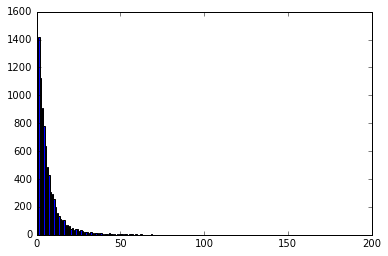

In [188]:
plt.bar(keys, values)

### Average links

In [ ]:
from MRJobGraph71 import MRJobGraph71d

mr_job = MRJobGraph71d(args=['s3://chrisdailey-mrjob/synNet.txt', '--no-strict-protocol', '-r', 'emr', '--conf-path', 'mrjob2.conf'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        print value

2016-03-09 23:21:50,004 boto [DEBUG]:Using access key provided by client.
DEBUG:boto:Using access key provided by client.
2016-03-09 23:21:50,005 boto [DEBUG]:Using secret key provided by client.
DEBUG:boto:Using secret key provided by client.
2016-03-09 23:21:50,006 boto [DEBUG]:path=/
DEBUG:boto:path=/
2016-03-09 23:21:50,007 boto [DEBUG]:auth_path=/
DEBUG:boto:auth_path=/
2016-03-09 23:21:50,008 boto [DEBUG]:Method: GET
DEBUG:boto:Method: GET
2016-03-09 23:21:50,009 boto [DEBUG]:Path: /
DEBUG:boto:Path: /
2016-03-09 23:21:50,009 boto [DEBUG]:Data: 
DEBUG:boto:Data: 
2016-03-09 23:21:50,010 boto [DEBUG]:Headers: {}
DEBUG:boto:Headers: {}
2016-03-09 23:21:50,011 boto [DEBUG]:Host: s3.amazonaws.com
DEBUG:boto:Host: s3.amazonaws.com
2016-03-09 23:21:50,012 boto [DEBUG]:Port: 443
DEBUG:boto:Port: 443
2016-03-09 23:21:50,013 boto [DEBUG]:Params: {}
DEBUG:boto:Params: {}
2016-03-09 23:21:50,014 boto [DEBUG]:establishing HTTPS connection: host=s3.amazonaws.com, kwargs={'port': 443, 'timeout

## HW 7.2
Write an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset. 

Proof your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

In [21]:
SSSP('./Data/synNet/synNet.txt','7827', '536')

Prep time: 0.60

Iteration 1:
	Time: 1.67s
Iteration 2:
	Time: 3.33s
Iteration 3:
	Time: 5.11s
Iteration 4:
536	3: [7827, 1426, 1668, 536]
Iterations: 4
Total time: 7.41s


In [20]:
SSSP("undirected_toy.txt","3", "5")

Prep time: 0.01

Iteration 1:
	Time: 0.02s
Iteration 2:
	Time: 0.04s
Iteration 3:
5	2: [3, 2, 5]
Iterations: 3
Total time: 0.05s


In [51]:
#!python mrjob/tools/emr/create_job_flow.py --num-ec2-instances=12
!python -m mrjob.tools.emr.create_job_flow --num-ec2-instances=5 '--conf-path' './mrjob2.conf' '--ec2-key-pair' 'general_aws'

using existing scratch bucket mrjob-8a1406e1a85a95ae
using s3://mrjob-8a1406e1a85a95ae/tmp/ as our scratch dir on S3
Creating persistent job flow to run several jobs in...
creating tmp directory /tmp/no_script.ubuntu.20160310.032619.356800
writing master bootstrap script to /tmp/no_script.ubuntu.20160310.032619.356800/b.py
Copying non-input files into s3://mrjob-8a1406e1a85a95ae/tmp/no_script.ubuntu.20160310.032619.356800/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-36EZFFK7A82YO
j-36EZFFK7A82YO


In [70]:
!pwd

/home/ubuntu/repos/261/week7


In [52]:
SSSP('s3://chrisdailey-mrjob/undirected_toy.txt','1', '5', 'j-36EZFFK7A82YO')

ERROR:mrjob.emr:Job on job flow j-36EZFFK7A82YO failed with status WAITING: Cluster ready after last step failed.


Prep time: 187.19

Iteration 1:


Exception: Operation requires job flow to terminate, but it may never do so.

## Using Ted's Code

In [53]:
%%writefile init_data.py

from sys import maxint
from mrjob.job import MRJob
from mrjob.step import MRStep

class initGraphJob(MRJob):
    
    def configure_options(self):
        super(initGraphJob, self).configure_options()
        self.add_passthrough_option('--startNode', default = '1')
    
    def mapper(self, _, node):
        nodeID, links = node.split('\t') #split on input tab
        links = eval(links) #make a dictionary
        
        if nodeID == self.options.startNode: 
            yield nodeID, (links.keys(), 0, 'Q', [nodeID]) #sets up start node
        else:
            yield nodeID, (links.keys(), maxint, 'U', [])
            
    def steps(self):
        return [MRStep(mapper = self.mapper)]

if __name__ == "__main__":
    initGraphJob.run()

Writing init_data.py


In [54]:
%%writefile shortestPathJob.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys

class ShortestPathJob(MRJob):
    
    def mapper(self, _, line):
        newline = line.strip().split('\t')
        
        node = eval(newline[0])
        
        data = eval(newline[1])
        neighbors = (data[0])
        distance = int(data[1])
        label = data[2]
        path = data[3]
        
        if label == 'Q':
            for neighbor in neighbors:
                newPath = list(path)
                newPath.append(neighbor)
                yield neighbor, [None, distance + 1, 'Q', newPath]
            yield node, [neighbors, distance, 'V', path]
        else:
            yield node, [neighbors, distance, label, path]
     

    
    def reducer(self, key, values):
        #By default assume a node is unvisited with an empty list of neighbors, makes updating below easier
        neighbors = [] 
        distance = sys.maxint
        label = 'U'
        path = []
        
        for value in values:
            
            temp_neighbors = value[0]
            temp_distance = value[1]
            temp_label = value[2]
            temp_path = value[3]
            
            if temp_label == 'V':
                neighbors = temp_neighbors
                distance = temp_distance
                label = temp_label
                path = temp_path
                break
            
            elif temp_label == 'Q':
                label = temp_label
                distance = temp_distance
                path = temp_path
                
            elif temp_label == 'U':
                neighbors = temp_neighbors
                
        yield key, [neighbors, distance, label, path]
        
        
            
if __name__ == '__main__':
    ShortestPathJob.run()

Writing shortestPathJob.py


In [55]:
from init_data import initGraphJob
from shortestPathJob import ShortestPathJob

def findShortestPath2(filename, startNode, endNode, clusterID):
    
    counter = 0
    
    mr_job_init = initGraphJob(args = [filename, '--startNode', startNode,
                                      '--no-strict-protocols', '-r', 'emr', 
                                      '--emr-job-flow-id', clusterID,
                                      '--output-dir', 's3://chrisdailey-mrjob/mrjob/hw7output' + str(counter),
                                      '--no-output']) 
  

    with mr_job_init.make_runner() as runner:
        runner.run()


    iterate = True
    while iterate:
        counter += 1
        mr_job = ShortestPathJob(args = ['s3://chrisdailey-mrjob/mrjob/hw7output' + str(counter - 1) + '/', 
                                        '--no-strict-protocols', '-r', 'emr',
                                        '--emr-job-flow-id', clusterID,
                                        '--output-dir', 's3://chrisdailey-mrjob/mrjob/hw7output' + str(counter),
                                        '--no-output'])
        with mr_job.make_runner() as runner:
            runner.run()
            for line in runner.stream_output():
                output = mr_job.parse_output_line(line)
                if output[0] == endNode and output[1][2] == "V":
                    print "The path is: " + str(output[1][3])
                    print "In a distance of: " + str(output[1][1]) #path
                    iterate = False
                    break

In [56]:
findShortestPath2('s3://chrisdailey-mrjob/directed_toy.txt', '1', '5', 'j-36EZFFK7A82YO')

The path is: [u'1', u'2', u'4', u'5']
In a distance of: 3
